Linear Regression 

Required Libraries

In [30]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm

import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [31]:
class LinearRegression :
    
    def __init__(self, X, y, learningRate, tolerance, maxIteration=50000, gd= False, sgd= False, regularization = False, lamda=1, sigma=1 ) :
        #np.random_state(10)
        self.X = X
        self.y = y
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.tolerance = tolerance
        self.gd = gd
        self.sgd = sgd
        self.regularization = regularization
        self.lamda = lamda
        self.sigma = sigma
        
    
    # Preparing the data to be loaded to the model
    
    def trainTestSplit(self):
        
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state = 0)
        
        return X_train, X_test, y_train, y_test
    
    def add_x0(self, X):

        return np.column_stack ([np.ones(X.shape[0]), X])
    
    def normalize(self, X):
        
        mean = np.mean(X, 0)
        sd = np.std(X, 0)
        
        X_norm = (X - mean) / sd
        X_norm = self.add_x0(X_norm)
        
        return X_norm, mean, sd
    
    def normalizeTestData(self, X, train_mean, train_std):
        
        X_norm = (X - train_mean) / train_std
        X_norm = self.add_x0(X_norm)
        
        return X_norm
    
    # Validating the data to check if it can be used to train the linear regression model
    
    def rank(self, X, eps = 1e-12):
        
        u, s, vh = np.linalg.svd(X)
        
        return len([x for x in s if abs(x) > eps])
    
    def checkMatrix(self, X):
        
        X_rank = np.linalg.matrix_rank(X)
        
        if X_rank == min(X.shape[0], X.shape[1]):
            
            print("Matrix is full rank")
            self.fullRank = True 
            
        else :
            
            print("Matrix is not full rank")
            self.fullRank = False
            
            
    def checkInvertability(self, X):
        
        if X.shape[0] < X.shape[1] :
            
            self.lowRank = True 
            print("Data is low rank")
            
        else :
            
            self.lowRank = False
            print("Data is not low rank")
            
    
    # Creating the model
    
    def closedFormSolution(self, X, y):
        
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
        return w
    
    def closedFormSolutionRegularized (self, X, y):
        
        w = np.linalg.inv(X.T.dot(X) + 2 * self.lamda * self.sigma * self.sigma * np.eye(X.shape[1])).dot(X.T).dot(y)
        
        return w     
    
    def gradientDescent(self, X, y):
        
        self.errorSequence = []
        self.costValues = []
        last = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            
            self.w = self.w - self.learningRate * self.costDerivatives(X, y)
            
            cost = self.costFunction(X, y)
            self.costValues.append(cost)
            
            cur = self.sse(X, y)
            
            diff = last - cur
            last = cur
            
            self.errorSequence.append(cur)
            
            if (diff < self.tolerance) : 
                
                print("The model stopped")
                
                break
               
    def sGradientDescent(self, X, y):
        
        self.errorSequence = []
        self.costValues = []
        last = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            
            for x_i, y_i in zip(X, y):
                self.w = self.w - self.learningRate * self.costDerivatives(x_i, y_i)
            
            cost = self.costFunction(X, y)
            self.costValues.append(cost)

            cur = self.sse(X, y)
            diff = last - cur
            last = cur
            self.errorSequence.append(cur)
            
            if (diff < self.tolerance) : 
                print("The model stopped")
                break
                
                
    def gradientDescentRegularized(self, X, y):
        
        self.errorSequence = []
        self.costValues = []
        last = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            
            self.w = self.w - self.learningRate * self.costDerivativesRegularized(X, y)
            
            cost = self.costFunctionRegularized(X, y)
            self.costValues.append(cost)

            cur = self.sse(X, y)
            diff = last - cur
            last = cur
            self.errorSequence.append(cur)
            
            if (diff < self.tolerance) : 
                print("The model stopped")
                break
                
    def sGradientDescentRegularized(self, X, y):
        
        self.errorSequence = []
        self.costValues = []
        last = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            
            for x_i, y_i in zip(X, y):
                self.w = self.w - self.learningRate * self.costDerivativesRegularized(x_i, y_i)
            
            cost = self.costFunctionRegularized(X,y)
            self.costValues.append(cost)

            cur = self.sse(X, y)
            diff = last - cur
            last = cur
            self.errorSequence.append(cur)
            
            if (diff < self.tolerance) : 
                print("The model stopped")
                break
                
    def costFunction(self, X, y):
        
        return (self.sse(X, y)/2)
        
        
    def costFunctionRegularized(self, X, y):
        
        return (self.sse(X, y) / (2 * self.sigma * self.sigma) ) + self.lamda * self.w.T.dot(self.w)
        
    def costDerivatives (self, X, y) :
        
        y_hat = self.predict(X)
        
        if (self.sgd == False):
            
            return ((y_hat - y).dot(X) )
        
        else:
            
            return ((y_hat - y) * (X) )
    
    def costDerivativesRegularized ( self, X, y):
        
        y_hat = self.predict(X)
        
        if (self.sgd == False):
            
            return ((y_hat - y).dot(X) / (self.sigma * self.sigma)) + 2 * self.lamda * self.w
        
        else:
            
            return ((y_hat - y) * (X) / (self.sigma * self.sigma)) + 2 * self.lamda * self.w
    
                
    def predict (self, X):
        
        return (X.dot(self.w))
        
    def sse(self, X, y):
        
        y_hat = self.predict(X)
        
        return ((y_hat - y)**2).sum()
        
    
    # Running the model
    
    def fit(self) :
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.trainTestSplit()
        
        self.X_train, self.mean, self.std = self.normalize ( self.X_train)
        self.X_test = self.normalizeTestData(self.X_test, self.mean, self.std)
        
        self.checkMatrix(self.X_train)
        self.checkInvertability(self.X_train)
        
        if self.fullRank and not self.lowRank and self.X_train.shape[0] < 10000 and not self.gd and not self.sgd and not self.regularization:
            
            print("\nSolving using closed form solution")
            
            self.w = self.closedFormSolution(self.X_train, self.y_train)
        
        elif self.fullRank and not self.lowRank and self.X_train.shape[0] < 10000 and self.gd and not self.sgd and not self.regularization :
            
            print("\nSolving using gradient descent")
            
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) *0
            
            self.gradientDescent(self.X_train, self.y_train)
            
            self.plotCost()
            
        elif self.fullRank and not self.lowRank and self.X_train.shape[0] < 10000 and not self.gd and not self.sgd and self.regularization :
            
            print("\nSolving using closed form regularised solution")
            
            self.w = self.closedFormSolutionRegularized(self.X_train, self.y_train)
            
        elif self.fullRank and not self.lowRank and self.X_train.shape[0] < 10000 and self.gd and not self.sgd and self.regularization :
            
            print("\nSolving using gradient descent regularised")
            
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) *0
            
            self.gradientDescentRegularized(self.X_train, self.y_train)
            
            self.plotCost()
            
        elif self.fullRank and not self.lowRank and self.X_train.shape[0] < 10000 and self.gd and self.sgd and not self.regularization :
            
            print("\nSolving using stochastic gradient descent")
            
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) *0
            
            self.sGradientDescent(self.X_train, self.y_train)
            
            self.plotCost()
            
        elif self.fullRank and not self.lowRank and self.X_train.shape[0] < 10000 and self.gd and self.sgd and self.regularization :
            
            print("\nSolving using stochastic gradient descent regularised")
            
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) *0
            
            self.sGradientDescentRegularized(self.X_train, self.y_train)
            
            self.plotCost()
        
        else :
            
            print("Incorrect parameters")
            
        
        
        sse = self.sse(self.X_test, self.y_test)
        rmse = math.sqrt(sse)
        print("\nSSE : ",  sse)
        print("RMSE : ", rmse )
        
        print("\nWeights \n")
        print(self.w)
        
    # PLotting the costs
    
    def plotCost(self):
        plt.plot(self.costValues)
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.title("Iterations vs cost")
        plt.show()

Housing Data

In [32]:
df = pd.read_csv("housing.csv", header=None)
lr = 0.4e-3
tolerance = 0.5e-2

In [33]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using closed form solution

SSE :  4133.7837519551285
RMSE :  64.29450794550907

Weights 

[22.74548023 -1.01189299  1.05028731  0.07922238  0.61896311 -1.87367112
  2.70526765 -0.27955798 -3.09763515  2.09690865 -1.88608488 -2.26109811
  0.58264435 -3.44050512]


Matrix is full rank
Data is not low rank

Solving using gradient descent


 36%|█████████████▍                       | 363/1000 [00:00<00:00, 38489.58it/s]

The model stopped


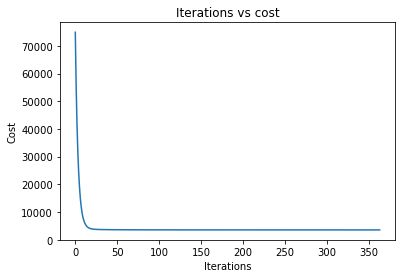


SSE :  4138.392640507719
RMSE :  64.33033996884922

Weights 

[22.74548023 -1.00695704  1.04172285  0.05071163  0.62307035 -1.86558657
  2.71080706 -0.28572203 -3.09874371  2.02599784 -1.80638574 -2.25793522
  0.58123396 -3.4382458 ]


In [34]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True)
regression.fit()

In [35]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             regularization = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using closed form regularised solution

SSE :  4161.106709870843
RMSE :  64.50664081992522

Weights 

[22.61769663 -0.99268609  1.01379307  0.0229338   0.62813902 -1.79856439
  2.72536211 -0.29071129 -3.02112681  1.93296858 -1.73402235 -2.24323351
  0.58326607 -3.40905681]


Matrix is full rank
Data is not low rank

Solving using gradient descent regularised


 43%|███████████████▊                     | 427/1000 [00:00<00:00, 29342.81it/s]

The model stopped


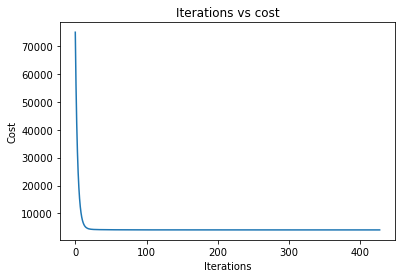


SSE :  4162.892453361971
RMSE :  64.52048088291012

Weights 

[ 2.26176966e+01 -9.90883844e-01  1.01066561e+00  1.24841431e-02
  6.29643090e-01 -1.79567456e+00  2.72737434e+00 -2.92952972e-01
 -3.02158078e+00  1.90698660e+00 -1.70478622e+00 -2.24208810e+00
  5.82744447e-01 -3.40823882e+00]


In [36]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True,
                             regularization = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using stochastic gradient descent


 36%|█████████████▉                         | 356/1000 [00:00<00:00, 774.52it/s]


The model stopped


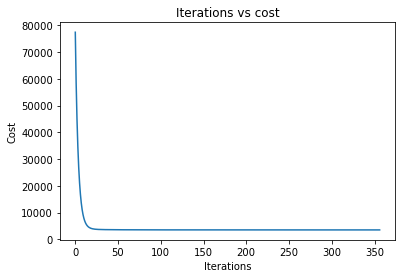


SSE :  4132.3486261016005
RMSE :  64.2833464133721

Weights 

[22.75420343 -1.02351594  1.04629644  0.06141644  0.65246888 -1.86039292
  2.7226557  -0.27177725 -3.10847954  2.0409238  -1.79535783 -2.27524424
  0.58302412 -3.44268508]


In [37]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True,
                             sgd = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using stochastic gradient descent regularised


  4%|█▍                                      | 37/1000 [00:00<00:02, 396.80it/s]

The model stopped


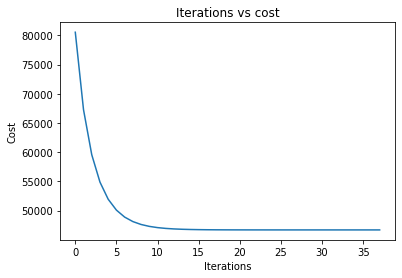


SSE :  39976.61435499176
RMSE :  199.94152733984944

Weights 

[ 7.60450056 -0.46918582  0.46133433 -0.53774611  0.44138981 -0.37907558
  1.52878998 -0.32315076 -0.20028833 -0.22407221 -0.45956926 -1.05815305
  0.45883531 -1.35727163]


In [38]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True,
                             sgd = True,
                             regularization = True)
regression.fit()

Yacht Data 

In [39]:
df = pd.read_csv("yachtData.csv", header=None)
lr = 0.1e-2
tolerance = 0.1e-2

In [40]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using closed form solution

SSE :  7205.10823485175
RMSE :  84.88290896789383

Weights 

[11.23939535  0.81790302  0.20369276  2.97602416 -2.75890138 -3.83325201
 12.9328097 ]


Matrix is full rank
Data is not low rank

Solving using gradient descent


 33%|███████████▊                        | 1643/5000 [00:00<00:00, 50867.26it/s]

The model stopped


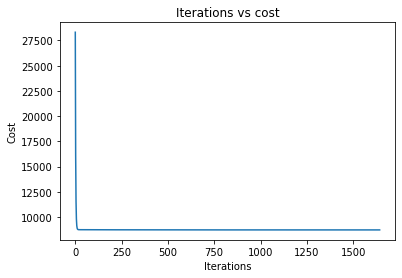


SSE :  7195.78106353937
RMSE :  84.82794977800283

Weights 

[11.23939535  0.81522178  0.13102656  2.68675502 -2.5228081  -3.55339498
 12.93260437]


In [41]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 5000 ,
                             tolerance = tolerance,
                             gd = True)
regression.fit()

In [42]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             regularization = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using closed form regularised solution

SSE :  7089.283775070544
RMSE :  84.19788462349005

Weights 

[11.13580645  0.79649758 -0.27701335  1.04108721 -1.1829239  -1.96027042
 12.81242845]


Matrix is full rank
Data is not low rank

Solving using gradient descent regularised


 25%|████████▉                           | 1247/5000 [00:00<00:00, 40159.84it/s]

The model stopped


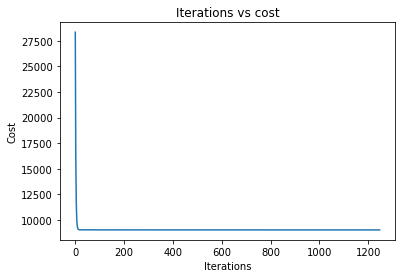


SSE :  7088.842841775688
RMSE :  84.19526614825615

Weights 

[11.13580645  0.79632786 -0.28161316  1.0227763  -1.16797906 -1.94255531
 12.81241545]


In [43]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 5000 ,
                             tolerance = tolerance,
                             gd = True,
                             regularization = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using stochastic gradient descent


 31%|███████████▌                         | 1557/5000 [00:01<00:02, 1298.61it/s]


The model stopped


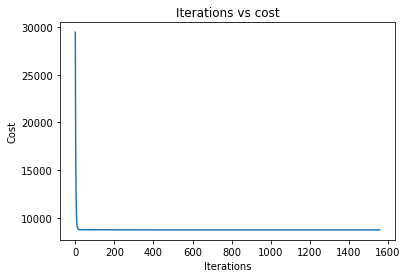


SSE :  7170.529996798601
RMSE :  84.67898202504918

Weights 

[11.20880961  0.81245218  0.13318449  2.72268506 -2.5806239  -3.58958195
 12.84249253]


In [44]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 5000 ,
                             tolerance = tolerance,
                             gd = True,
                             sgd = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using stochastic gradient descent regularised


  1%|▏                                       | 26/5000 [00:00<00:08, 560.96it/s]

The model stopped


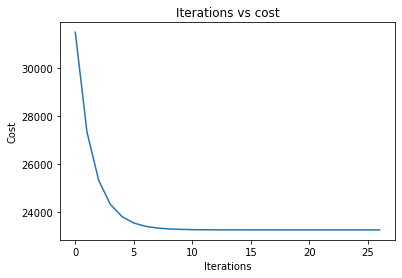


SSE :  12871.555977596721
RMSE :  113.45287998811102

Weights 

[ 3.68163699  0.26035163 -0.30535121 -0.19298314 -0.057174   -0.27013373
  4.19808199]


In [45]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 5000 ,
                             tolerance = tolerance,
                             gd = True,
                             sgd = True,
                             regularization = True)
regression.fit()

Concrete Data

In [46]:
df = pd.read_csv("concreteData.csv", header=None)
lr = 0.7e-3
tolerance = 0.1e-3

In [47]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using closed form solution

SSE :  28928.189419662704
RMSE :  170.0828898498103

Weights 

[35.85368932 12.72547471  9.54463305  5.99752761 -2.82130272  2.10540297
  1.85195151  1.95023318  7.17433735]


Matrix is full rank
Data is not low rank

Solving using gradient descent


 44%|████████████████▋                     | 440/1000 [00:00<00:00, 1709.04it/s]


The model stopped


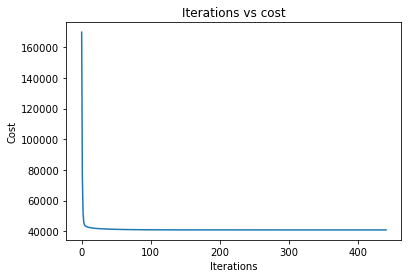


SSE :  28927.518884460915
RMSE :  170.08091863716197

Weights 

[35.85368932 12.72033523  9.53947715  5.99298714 -2.82570188  2.10479451
  1.84789054  1.94520372  7.17419989]


In [48]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True)
regression.fit()

In [49]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             regularization = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using closed form regularised solution

SSE :  28952.417252139392
RMSE :  170.15409854640407

Weights 

[35.75450899 12.22986534  9.04984634  5.55403896 -3.15069474  2.10452505
  1.51020192  1.51209823  7.13320331]


Matrix is full rank
Data is not low rank

Solving using gradient descent regularised


 66%|█████████████████████████▏            | 663/1000 [00:00<00:00, 2257.07it/s]


The model stopped


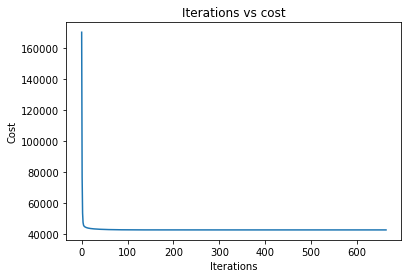


SSE :  28952.412201258696
RMSE :  170.15408370432576

Weights 

[35.75450899 12.22981225  9.04979309  5.55399206 -3.15074018  2.10451877
  1.51015997  1.51204628  7.13320189]


In [50]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True,
                             regularization = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using stochastic gradient descent


 42%|████████████████▍                      | 422/1000 [00:01<00:01, 388.35it/s]


The model stopped


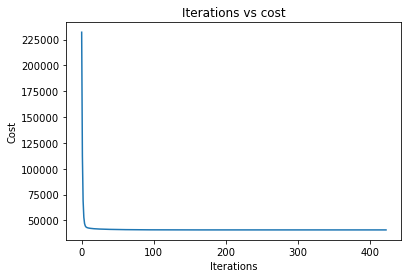


SSE :  28891.552995356025
RMSE :  169.97515405304395

Weights 

[35.84622017 12.74059009  9.53147994  6.01508254 -2.7451715   2.10638501
  1.76835981  1.90421032  7.15384662]


In [51]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True,
                             sgd = True)
regression.fit()

Matrix is full rank
Data is not low rank

Solving using stochastic gradient descent regularised


  2%|▋                                       | 16/1000 [00:00<00:05, 192.09it/s]

The model stopped


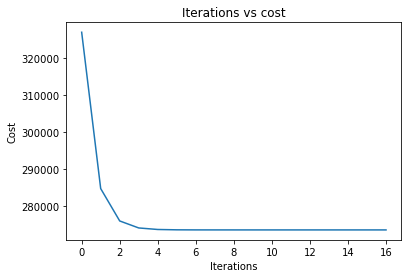


SSE :  228477.30522746517
RMSE :  477.9929970485605

Weights 

[11.97520655  2.66603479  1.00134062 -0.60954137 -1.74737202  1.9003655
 -0.82404711 -0.94651019  1.94941303]


In [52]:
regression = LinearRegression(df.values[:,0:-1], df.values[:,-1], 
                             learningRate = lr,
                             maxIteration = 1000 ,
                             tolerance = tolerance,
                             gd = True,
                             sgd = True,
                             regularization = True)
regression.fit()

When you use low learning rate, the model takes time to train data and there will be high chance to reach the convergence. While plotting the cost function we get the smoother curve, and by adding the regularization parameter, it increase the error on the training data but it gives a better result on the test data by preventing overfitting. 
Yacht data has learning rate high, so we can observe that it has sharp curve where as housing data has lower learning rate  so it has smoother curve when compare to yacht data. 